In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
"""
    Pulls an unsupervised fine tuned model from disk, also data, and goes to town on it.
"""

import html
import os
import pickle
# External Lib imports
import re
from functools import partial
from pathlib import Path

import pandas as pd

os.environ['QT_QPA_PLATFORM'] = 'offscreen'

# FastAI Imports
from fastai import text, core, lm_rnn

# Torch imports
import torch.nn as nn
import torch.optim as optim

# Mytorch imports
from mytorch import loops, lriters as mtlr, dataiters as mtdi
from mytorch.utils.goodies import *

device = torch.device('cuda')
np.random.seed(42)
torch.manual_seed(42)
'''
    Paths and macros
'''

DEBUG = True
DANN = True
TRIM = True

# Path fields
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH = Path('raw/imdb/aclImdb/')
DATA_PATH.mkdir(exist_ok=True)
PATH = Path('resources/proc/imdb')
DATA_PROC_PATH = PATH / 'data'
DATA_LM_PATH = PATH / 'datalm'

LM_PATH = Path('resources/models')
LM_PATH.mkdir(exist_ok=True)
PRE_PATH = LM_PATH / 'wt103'
PRE_LM_PATH = PRE_PATH / 'fwd_wt103.h5'
CLASSES = ['neg', 'pos', 'unsup']

src = 'dann' if DANN else 'phase2'
datasize = 'trim' if TRIM else 'full'
DUMPPATH = PATH / f'{src}_{datasize}_default'

'''
    Model code
'''
class CustomEncoder(lm_rnn.MultiBatchRNN):
    @property
    def layers(self):
        # TODO: ADD ENCODERR!!!!!!!!!!
        return torch.nn.ModuleList([torch.nn.ModuleList([self.rnns[0], self.dropouths[0]]),
                                    torch.nn.ModuleList([self.rnns[1], self.dropouths[1]]),
                                    torch.nn.ModuleList([self.rnns[2], self.dropouths[2]])])


class TextClassifier(nn.Module):

    # @TODO: inject comments.
    def __init__(self, _device: torch.device, ntoken: int, dps: list, enc_wgts, _debug=False):
        super(TextClassifier, self).__init__()

        self.device = _device

        # Load the pre-trained model
        args = {'ntoken': ntoken, 'emb_sz': 400, 'n_hid': 1150,
                'n_layers': 3, 'pad_token': 0, 'qrnn': False, 'bptt': 70, 'max_seq': 1400,
                'dropouti': dps[0], 'wdrop': dps[1], 'dropoute': dps[2], 'dropouth': dps[3]}
        self.encoder = CustomEncoder(**args).to(self.device)
        self.encoder.load_state_dict(enc_wgts)
        '''
            Make new classifier.
            
            Explanation:
                400*3 because input is [ h_T, maxpool, meanpool ]
                50 is hidden layer dim
                2 is n_classes

                0.4, 0.1 are drops at various layers
        '''
        self.linear = text.PoolingLinearClassifier(layers=[400 * 3, 50, 2], drops=[dps[4], 0.1]).to(self.device)
        self.encoder.reset()

    @property
    def layers(self):
        layers = [x for x in self.encoder.layers]
        layers += [x for x in self.linear.layers]
        return torch.nn.ModuleList(layers)

    @property
    def layers_rev(self):
        layers = [x for x in self.encoder.layers]
        layers += [x for x in self.linear.layers]
        layers.reverse()
        return torch.nn.ModuleList(layers)

    def forward(self, x):
        # inputs are S*B

        # Encoding all the data
        op_p = self.encoder(x.transpose(1, 0))
        # pos_batch = op_p[1][-1][-1]
        score = self.linear(op_p)[0]

        return score

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            predicted = self.forward(x)
            self.train()
            return predicted


'''
    Prepare data
'''
re1 = re.compile(r'  +')


def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df.iloc[:, 1].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = text.Tokenizer().proc_all_mp(core.partition_by_cores(texts))
    return tok, list(labels)


def get_all(df, n_lbls):
    tok, labels = get_texts(df)
    return tok, labels


def get_texts_org(path):
    texts, labels = [], []
    for idx, label in enumerate(CLASSES):
        for fname in (path / label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)


'\n    Pulls an unsupervised fine tuned model from disk, also data, and goes to town on it.\n'

'\n    Paths and macros\n'

'\n    Model code\n'

'\n    Prepare data\n'

In [3]:
trn_texts, trn_labels = get_texts_org(DATA_PATH / 'train')
val_texts, val_labels = get_texts_org(DATA_PATH / 'test')

# Lose label 2 from train
trn_texts = trn_texts[trn_labels<2]
trn_labels = trn_labels[trn_labels<2]

# Shuffle data
if TRIM:
    np.random.seed(42)
    trn_idx = np.random.permutation(len(trn_texts))[:1000]
    val_idx = np.random.permutation(len(val_texts))[:1000]
else:
    np.random.seed(42)
    trn_idx = np.random.permutation(len(trn_texts))
    val_idx = np.random.permutation(len(val_texts))

trn_texts, trn_labels = trn_texts[trn_idx], trn_labels[trn_idx]
val_texts, val_labels = val_texts[val_idx], val_labels[val_idx]
col_names = ['labels', 'text']

df_trn = pd.DataFrame({'text': trn_texts, 'labels': trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text': val_texts, 'labels': val_labels}, columns=col_names)

itos_path = DUMPPATH / 'itos.pkl'
itos2 = pickle.load(itos_path.open('rb'))
stoi2 = {v: k for k, v in enumerate(itos2)}

trn_clas, trn_labels = get_all(df_trn, 1)
val_clas, val_labels = get_all(df_val, 1)

trn_clas = np.array([[stoi2.get(w, 0) for w in para] for para in trn_clas])
val_clas = np.array([[stoi2.get(w, 0) for w in para] for para in val_clas])
trn_labels = [x for y in trn_labels for x in y]
val_labels = [x for y in val_labels for x in y]

In [4]:
'''
    Make model
'''
dps = list(np.asarray([0.4, 0.5, 0.05, 0.3, 0.4]) * 0.5)
# enc_wgts = torch.load(LM_PATH, map_location=lambda storage, loc: storage)
enc_wgts = torch.load(DUMPPATH / 'unsup_model_enc.torch', map_location=lambda storage, loc: storage)
clf = TextClassifier(device, len(itos2), dps, enc_wgts)

'''
    Setup things for training (data, loss, opt, lr schedule etc
'''
bs = 24
loss_fn = torch.nn.CrossEntropyLoss()
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
opt = make_opt(clf, opt_fn, lr=0.0)
opt.param_groups[-1]['lr'] = 0.01

# Make data
data_fn = partial(mtdi.SortishSampler, _batchsize=bs, _padidx=1)
data = {'train': {'x': trn_clas, 'y': trn_labels}, 'valid': {'x': val_clas, 'y': val_labels}}

# Make lr scheduler
lr_args = {'iterations': len(data_fn(data['train'])), 'cycles': 1}
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)


def epoch_end_hook() -> None:
    lr_schedule.reset()


def eval(y_pred, y_true):
    """
        Expects a batch of input

        :param y_pred: tensor of shape (b, nc)
        :param y_true: tensor of shape (b, 1)
    """
    return torch.mean((torch.argmax(y_pred, dim=1) == y_true).float())


'\n    Make model\n'

'\n    Setup things for training (data, loss, opt, lr schedule etc\n'

[0.0, 0.0, 0.0, 0.0, 0.01]


In [5]:
args = {'epochs': 1, 'data': data, 'device': device,
        'opt': opt, 'loss_fn': loss_fn, 'model': clf,
        'train_fn': clf, 'predict_fn': clf.predict,
        'epoch_end_hook': epoch_end_hook, 'weight_decay': 1e-7,
        'clip_grads_at': 0.30, 'lr_schedule': lr_schedule,
        'data_fn': data_fn, 'eval_fn': eval}

In [6]:
traces = loops.generic_loop(**args)

100%|██████████| 42/42 [00:04<00:00, 10.40it/s]

Epoch: 000 | Loss: 0.69539 | Tr_c: 0.54960 | Vl_c: 0.54762 | Time: 0.177 min


In [7]:
opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
opt.param_groups[-4]['lr'] = 0.001
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
opt.param_groups[-4]['lr'] = 0.001
opt.param_groups[-5]['lr'] = 0.001
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
opt.param_groups[-4]['lr'] = 0.001
opt.param_groups[-5]['lr'] = 0.001
lr_args['cycles'] = 3 # TODO: find real value here!!!
# lr_args['iterations'] *= 15
args['epochs'] = 15
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

  0%|          | 0/42 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.005, 0.01]


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 000 | Loss: 0.59862 | Tr_c: 0.67808 | Vl_c: 0.74752 | Time: 0.177 min
[0.0, 0.0, 0.001, 0.005, 0.01]


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 000 | Loss: 0.54302 | Tr_c: 0.73611 | Vl_c: 0.74851 | Time: 0.177 min
[0.0, 0.001, 0.001, 0.005, 0.01]


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 000 | Loss: 0.44678 | Tr_c: 0.80357 | Vl_c: 0.81647 | Time: 0.176 min
[0.001, 0.001, 0.001, 0.005, 0.01]


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 000 | Loss: 0.36775 | Tr_c: 0.84325 | Vl_c: 0.83234 | Time: 0.178 min
[0.001, 0.001, 0.001, 0.005, 0.01]


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 000 | Loss: 0.25975 | Tr_c: 0.90675 | Vl_c: 0.84177 | Time: 0.177 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 001 | Loss: 0.23839 | Tr_c: 0.90476 | Vl_c: 0.80655 | Time: 0.178 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 002 | Loss: 0.16346 | Tr_c: 0.93998 | Vl_c: 0.84623 | Time: 0.177 min


  2%|▏         | 1/42 [00:00<00:05,  7.58it/s]

Epoch: 003 | Loss: 0.16428 | Tr_c: 0.94792 | Vl_c: 0.81002 | Time: 0.178 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 004 | Loss: 0.13339 | Tr_c: 0.95188 | Vl_c: 0.83085 | Time: 0.178 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 005 | Loss: 0.15895 | Tr_c: 0.95089 | Vl_c: 0.83978 | Time: 0.178 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 006 | Loss: 0.10256 | Tr_c: 0.95139 | Vl_c: 0.85813 | Time: 0.177 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 007 | Loss: 0.11228 | Tr_c: 0.96379 | Vl_c: 0.86310 | Time: 0.179 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 008 | Loss: 0.08807 | Tr_c: 0.97173 | Vl_c: 0.80258 | Time: 0.177 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 009 | Loss: 0.08050 | Tr_c: 0.97024 | Vl_c: 0.87252 | Time: 0.179 min


  2%|▏         | 1/42 [00:00<00:05,  7.33it/s]

Epoch: 010 | Loss: 0.04259 | Tr_c: 0.98611 | Vl_c: 0.86260 | Time: 0.178 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 011 | Loss: 0.07095 | Tr_c: 0.97966 | Vl_c: 0.86558 | Time: 0.178 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 012 | Loss: 0.07398 | Tr_c: 0.98115 | Vl_c: 0.83829 | Time: 0.178 min


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 013 | Loss: 0.06663 | Tr_c: 0.97470 | Vl_c: 0.84821 | Time: 0.178 min


100%|██████████| 42/42 [00:04<00:00, 11.24it/s]

Epoch: 014 | Loss: 0.06082 | Tr_c: 0.98413 | Vl_c: 0.85615 | Time: 0.178 min


In [8]:
# Dumping the traces
with open(DUMPPATH/'sup_traces.pkl', 'wb+') as fl:
    pickle.dump(traces, fl)

# Dumping the model
torch.save(clf.state_dict(), DUMPPATH / 'sup_model.torch')


In [ ]:
traces

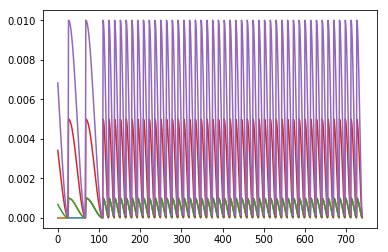

In [9]:
from matplotlib import pyplot as plt
def plot(trcs):
    layers = len(trcs[0])
    for l in range(layers):
        plt.plot(trcs[:,l], label=f"layer {l}")
    plt.show()
    
plot(np.asarray(traces[-1][100:]))

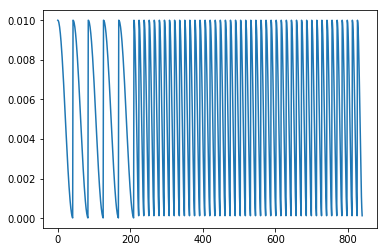

In [10]:
plot(np.asarray([[x[-1]] for x in traces[-1][:]]))

{'iterations': 42, 'cycles': 3}
[1.2536043909088191e-05, 1.2536043909088191e-05, 1.2536043909088191e-05, 6.268021954544095e-05, 0.0001253604390908819]


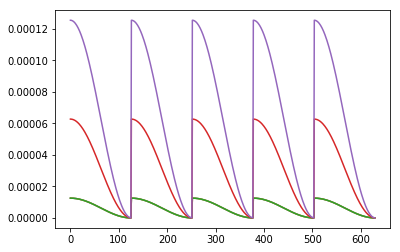

In [11]:
print(lr_args)
lr_args['cycles'] = 5
lr_args['iterations'] = 42*15
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
lrs = []
while True:
    try:
        lrs.append(lr_schedule.get())
    except CustomError:
        break
plot(np.asarray(lrs))